In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
import re

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

print("Imports complete!")

Imports complete!


In [2]:
faq_data = [
    {
        "question": "What is your return policy?",
        "answer": "We offer a 30-day return policy for all products."
    },
    {
        "question": "How long does shipping take?",
        "answer": "Standard shipping takes 5-7 business days."
    },
    {
        "question": "Do you ship internationally?",
        "answer": "Yes, we ship to over 50 countries worldwide."
    },
    {
        "question": "How can I track my order?",
        "answer": "You'll receive a tracking number via email once shipped."
    },
    {
        "question": "What payment methods do you accept?",
        "answer": "We accept all major credit cards, PayPal, and bank transfers."
    }
]

df = pd.DataFrame(faq_data)
print("Sample FAQs:")
print(df)

Sample FAQs:
                              question  \
0          What is your return policy?   
1         How long does shipping take?   
2         Do you ship internationally?   
3            How can I track my order?   
4  What payment methods do you accept?   

                                              answer  
0  We offer a 30-day return policy for all products.  
1         Standard shipping takes 5-7 business days.  
2       Yes, we ship to over 50 countries worldwide.  
3  You'll receive a tracking number via email onc...  
4  We accept all major credit cards, PayPal, and ...  


In [3]:
sample_text = "How Do I RETURN my Product?"
print(f"Original text: {sample_text}")
print("\n" + "="*60)

text = sample_text.lower()
print(f"1. Lowercase: {text}")

text = re.sub(r'[^a-zA-Z\s]', '', text)
print(f"2. Remove special chars: {text}")

tokens = word_tokenize(text)
print(f"3. Tokenize: {tokens}")

stop_words = set(stopwords.words('english'))
filtered_tokens = [t for t in tokens if t not in stop_words]
print(f"4. Remove stopwords: {filtered_tokens}")

lemmatizer = WordNetLemmatizer()
lemmatized = [lemmatizer.lemmatize(t) for t in filtered_tokens]
print(f"5. Lemmatize: {lemmatized}")

final_text = ' '.join(lemmatized)
print(f"\n✓ Final processed text: '{final_text}'")

Original text: How Do I RETURN my Product?

1. Lowercase: how do i return my product?
2. Remove special chars: how do i return my product
3. Tokenize: ['how', 'do', 'i', 'return', 'my', 'product']
4. Remove stopwords: ['return', 'product']
5. Lemmatize: ['return', 'product']

✓ Final processed text: 'return product'


In [4]:
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    processed = [
        lemmatizer.lemmatize(t) 
        for t in tokens 
        if t not in stop_words and len(t) > 2
    ]
    return ' '.join(processed)

questions = [faq['question'] for faq in faq_data]
preprocessed_questions = [preprocess_text(q) for q in questions]

comparison = pd.DataFrame({
    'Original': questions,
    'Preprocessed': preprocessed_questions
})
print("Before and After Preprocessing:")
print(comparison)

Before and After Preprocessing:
                              Original           Preprocessed
0          What is your return policy?          return policy
1         How long does shipping take?     long shipping take
2         Do you ship internationally?   ship internationally
3            How can I track my order?            track order
4  What payment methods do you accept?  payment method accept


In [5]:
vectorizer = TfidfVectorizer()
question_vectors = vectorizer.fit_transform(preprocessed_questions)

vocab = vectorizer.get_feature_names_out()
print(f"Vocabulary size: {len(vocab)}")
print(f"Vocabulary: {list(vocab)}")

tfidf_matrix = question_vectors.toarray()
tfidf_df = pd.DataFrame(
    tfidf_matrix,
    columns=vocab,
    index=[f"Q{i+1}" for i in range(len(questions))]
)
print("\nTF-IDF Matrix:")
print(tfidf_df.round(3))

print(f"\nTF-IDF for Q1 ('{questions[0]}'):")
q1_tfidf = tfidf_df.iloc[0]
print(q1_tfidf[q1_tfidf > 0].sort_values(ascending=False))

Vocabulary size: 12
Vocabulary: ['accept', 'internationally', 'long', 'method', 'order', 'payment', 'policy', 'return', 'ship', 'shipping', 'take', 'track']

TF-IDF Matrix:
    accept  internationally   long  method  order  payment  policy  return  \
Q1   0.000            0.000  0.000   0.000  0.000    0.000   0.707   0.707   
Q2   0.000            0.000  0.577   0.000  0.000    0.000   0.000   0.000   
Q3   0.000            0.707  0.000   0.000  0.000    0.000   0.000   0.000   
Q4   0.000            0.000  0.000   0.000  0.707    0.000   0.000   0.000   
Q5   0.577            0.000  0.000   0.577  0.000    0.577   0.000   0.000   

     ship  shipping   take  track  
Q1  0.000     0.000  0.000  0.000  
Q2  0.000     0.577  0.577  0.000  
Q3  0.707     0.000  0.000  0.000  
Q4  0.000     0.000  0.000  0.707  
Q5  0.000     0.000  0.000  0.000  

TF-IDF for Q1 ('What is your return policy?'):
policy    0.707107
return    0.707107
Name: Q1, dtype: float64


In [6]:
user_question = "Can I return my purchase?"
print(f"User question: {user_question}")

user_processed = preprocess_text(user_question)
print(f"Preprocessed: {user_processed}")

user_vector = vectorizer.transform([user_processed])

similarities = cosine_similarity(user_vector, question_vectors)[0]

results_df = pd.DataFrame({
    'FAQ Question': questions,
    'Similarity': similarities,
    'Percentage': (similarities * 100).round(2)
}).sort_values('Similarity', ascending=False)

print("\nSimilarity Scores:")
print(results_df)

best_idx = np.argmax(similarities)
print(f"\n✓ Best match: {questions[best_idx]}")
print(f"  Similarity: {similarities[best_idx]:.2%}")
print(f"  Answer: {faq_data[best_idx]['answer']}")

User question: Can I return my purchase?
Preprocessed: return purchase

Similarity Scores:
                          FAQ Question  Similarity  Percentage
0          What is your return policy?    0.707107       70.71
1         How long does shipping take?    0.000000        0.00
2         Do you ship internationally?    0.000000        0.00
3            How can I track my order?    0.000000        0.00
4  What payment methods do you accept?    0.000000        0.00

✓ Best match: What is your return policy?
  Similarity: 70.71%
  Answer: We offer a 30-day return policy for all products.


In [7]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
test_questions = [
    "How do I return items?",
    "What's the shipping time?",
    "What's the weather today?"
]

print("Threshold Testing Results:")
print("="*80)

for question in test_questions:
    print(f"\nQuestion: {question}")
    print("-"*80)
    
    user_processed = preprocess_text(question)
    user_vector = vectorizer.transform([user_processed])
    similarities = cosine_similarity(user_vector, question_vectors)[0]
    max_sim = np.max(similarities)
    
    for threshold in thresholds:
        if max_sim >= threshold:
            best_idx = np.argmax(similarities)
            result = f"✓ Match: {questions[best_idx][:40]}..."
        else:
            result = "✗ No match (fallback)"
        
        print(f"  Threshold {threshold:.1f}: {result} (sim={max_sim:.3f})")


Threshold Testing Results:

Question: How do I return items?
--------------------------------------------------------------------------------
  Threshold 0.1: ✓ Match: What is your return policy?... (sim=0.707)
  Threshold 0.2: ✓ Match: What is your return policy?... (sim=0.707)
  Threshold 0.3: ✓ Match: What is your return policy?... (sim=0.707)
  Threshold 0.4: ✓ Match: What is your return policy?... (sim=0.707)
  Threshold 0.5: ✓ Match: What is your return policy?... (sim=0.707)

Question: What's the shipping time?
--------------------------------------------------------------------------------
  Threshold 0.1: ✓ Match: How long does shipping take?... (sim=0.577)
  Threshold 0.2: ✓ Match: How long does shipping take?... (sim=0.577)
  Threshold 0.3: ✓ Match: How long does shipping take?... (sim=0.577)
  Threshold 0.4: ✓ Match: How long does shipping take?... (sim=0.577)
  Threshold 0.5: ✓ Match: How long does shipping take?... (sim=0.577)

Question: What's the weather today?
--------

In [8]:
class FAQChatbot:    
    def __init__(self, faq_data, similarity_threshold=0.3):
        self.faq_data = faq_data
        self.similarity_threshold = similarity_threshold
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        
        self.questions = [faq['question'] for faq in faq_data]
        self.answers = [faq['answer'] for faq in faq_data]
        
        self.preprocessed_questions = [
            self.preprocess_text(q) for q in self.questions
        ]
        
        self.vectorizer = TfidfVectorizer()
        self.question_vectors = self.vectorizer.fit_transform(
            self.preprocessed_questions
        )
    
    def preprocess_text(self, text):
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        tokens = word_tokenize(text)
        processed = [
            self.lemmatizer.lemmatize(t)
            for t in tokens
            if t not in self.stop_words and len(t) > 2
        ]
        return ' '.join(processed)
    
    def get_response(self, user_question):
        processed = self.preprocess_text(user_question)
        user_vector = self.vectorizer.transform([processed])
        similarities = cosine_similarity(user_vector, self.question_vectors)
        
        best_idx = np.argmax(similarities[0])
        best_sim = similarities[0][best_idx]
        
        if best_sim >= self.similarity_threshold:
            return {
                'answer': self.answers[best_idx],
                'confidence': round(best_sim * 100, 2),
                'matched_question': self.questions[best_idx]
            }
        else:
            return {
                'answer': "Sorry, I don't understand your question.",
                'confidence': round(best_sim * 100, 2),
                'matched_question': None
            }

chatbot = FAQChatbot(faq_data, similarity_threshold=0.3)
print("Chatbot initialized!")


Chatbot initialized!


In [9]:
test_questions = [
    "What's your return policy?",
    "How long for shipping?",
    "Can I track my order?",
    "What's the weather?",  # Out of scope
    "payment methods"
]

print("Testing the chatbot:")
print("="*80)

for question in test_questions:
    response = chatbot.get_response(question)
    
    print(f"\nQ: {question}")
    print(f"A: {response['answer'][:80]}...")
    print(f"Confidence: {response['confidence']}%")
    if response['matched_question']:
        print(f"Matched: {response['matched_question']}")
    print("-"*80)

Testing the chatbot:

Q: What's your return policy?
A: We offer a 30-day return policy for all products....
Confidence: 100.0%
Matched: What is your return policy?
--------------------------------------------------------------------------------

Q: How long for shipping?
A: Standard shipping takes 5-7 business days....
Confidence: 81.65%
Matched: How long does shipping take?
--------------------------------------------------------------------------------

Q: Can I track my order?
A: You'll receive a tracking number via email once shipped....
Confidence: 100.0%
Matched: How can I track my order?
--------------------------------------------------------------------------------

Q: What's the weather?
A: Sorry, I don't understand your question....
Confidence: 0.0%
--------------------------------------------------------------------------------

Q: payment methods
A: We accept all major credit cards, PayPal, and bank transfers....
Confidence: 81.65%
Matched: What payment methods do you acce

In [10]:
test_cases = [
    ("What is your return policy?", True),
    ("How do returns work?", True),
    ("Can I send items back?", True),
    ("What's the weather?", False),
    ("Tell me a joke", False),
]

correct = 0
for question, should_match in test_cases:
    response = chatbot.get_response(question)
    matched = response['matched_question'] is not None
    
    if matched == should_match:
        correct += 1
        status = "✓"
    else:
        status = "✗"
    
    print(f"{status} {question:40s} | Expected: {should_match:5} | Got: {matched:5}")

accuracy = (correct / len(test_cases)) * 100
print(f"\nAccuracy: {accuracy:.1f}%")

✓ What is your return policy?              | Expected:     1 | Got:     1
✓ How do returns work?                     | Expected:     1 | Got:     1
✗ Can I send items back?                   | Expected:     1 | Got:     0
✓ What's the weather?                      | Expected:     0 | Got:     0
✓ Tell me a joke                           | Expected:     0 | Got:     0

Accuracy: 80.0%


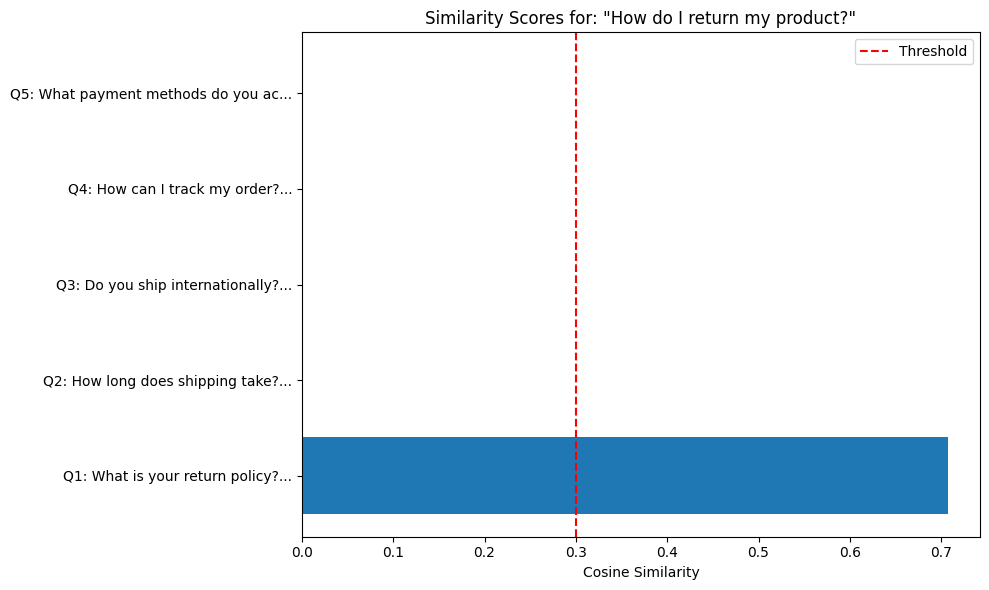

In [11]:
import matplotlib.pyplot as plt

test_q = "How do I return my product?"
user_processed = chatbot.preprocess_text(test_q)
user_vector = chatbot.vectorizer.transform([user_processed])
similarities = cosine_similarity(user_vector, chatbot.question_vectors)[0]

plt.figure(figsize=(10, 6))
plt.barh(range(len(questions)), similarities)
plt.yticks(range(len(questions)), 
           [f"Q{i+1}: {q[:30]}..." for i, q in enumerate(questions)])
plt.xlabel('Cosine Similarity')
plt.title(f'Similarity Scores for: "{test_q}"')
plt.axvline(x=0.3, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.tight_layout()
plt.show()